In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import numpy as np
import json
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from folium import plugins

In [2]:
df = pd.read_excel('Cabify_2010.xlsx')
df.head()

journey_id                           user_id  \
0  23a1406fc6a11d866e3c82f22eed4d4c  0e9af5bbf1edfe591b54ecdfd7e91e26   
1  dd2af4715d0dc16eded53afc0e243577  a553c46e3a22fb9c326aeb3d72b3334e   
2  dd91e131888064bf7df3ce08f3d4b4ad  a553c46e3a22fb9c326aeb3d72b3334e   
3  dd2af4715d0dc16eded53afc0e2466d0  a553c46e3a22fb9c326aeb3d72b3334e   
4  85b7eabcf5d84e42dc7629b7d27781af  56772d544fdfa589a020a1ff894a86f7   

                          driver_id                           taxi_id  \
0  583949a89a9ee17d19e3ca4f137b6b4c  b12f4f09c783e29fe0d0ea624530db56   
1                               NaN                               NaN   
2                               NaN                               NaN   
3                               NaN                               NaN   
4  d665fb9f75ef5d9cd0fd89479380ba78  0accdd3aa5a322f4129fa20b53278c69   

        icon start_type            start_at  start_lat  start_lon  \
0  executive       asap 2010-11-16 16:44:52 -12.139835 -77.023560   
1  executive       asap 2010-06-01 00:34:38 -12.138748 -76.995361   
2  executive       asap 2010-05-31 05:01:24 -12.124531 -77.027802   
3  executive       asap 2010-06-01 00:29:30 -12.138851 -76.995300   
4  executive   reserved 2010-09-11 23:55:00 -12.089954 -76.926270   

               end_at  ...  price_distance  price_duration distance  duration  \
0 2010-11-16 17:29:57  ...          3626.0           195.0  11331.0     234.0   
1 2010-06-01 00:37:39  ...             NaN             NaN      0.0       0.0   
2 2010-05-31 05:04:34  ...             NaN             NaN      0.0       0.0   
3 2010-06-01 00:32:35  ...             NaN             NaN      0.0       0.0   
4 2010-09-12 01:07:02  ...          7665.0           562.0  30270.0     715.0   

     cost cost_distance cost_duration  source  driver_score  rider_score  
0     0.0           0.0           0.0  iPhone           5.0          5.0  
1     0.0           NaN           NaN  iPhone           NaN          NaN  
2     0.0           NaN           NaN  iPhone           NaN          NaN  
3     0.0           NaN           NaN  iPhone           NaN          NaN  
4  6173.0        5756.0         417.0  iPhone           4.0          5.0  

[5 rows x 28 columns]

Running a data exploration to know more about the dataframe. 
Steps:
1. How many rows are there
2. Are there unique records or are there duplicated ones
3. Investigate a bit about the units used:  measurement for distance and duraion, currencies for price, time zones for starting and ending timestamps, etc. And if they are standardize across all records. 

### Knowing the dataframe

In [3]:
#Which are the different columns?

df.columns

Index(['journey_id', 'user_id', 'driver_id', 'taxi_id', 'icon', 'start_type',
       'start_at', 'start_lat', 'start_lon', 'end_at', 'end_lat', 'end_lon',
       'end_state', 'driver_start_lat', 'driver_start_lon', 'arrived_at',
       'currency', 'price', 'price_distance', 'price_duration', 'distance',
       'duration', 'cost', 'cost_distance', 'cost_duration', 'source',
       'driver_score', 'rider_score'],
      dtype='object')

In [4]:
print('There dataframe has',len(df.columns), 'columns related to all journeys during 2010 which store information related to the user, location, distance, price, cost and score.')

There dataframe has 28 columns related to all journeys during 2010 which store information related to the user, location, distance, price, cost and score.


In [5]:
#Which are the types of these columns?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23111 entries, 0 to 23110
Data columns (total 28 columns):
journey_id          23111 non-null object
user_id             23111 non-null object
driver_id           19726 non-null object
taxi_id             19726 non-null object
icon                23111 non-null object
start_type          23111 non-null object
start_at            23111 non-null datetime64[ns]
start_lat           23111 non-null float64
start_lon           23111 non-null float64
end_at              22835 non-null datetime64[ns]
end_lat             23111 non-null float64
end_lon             23111 non-null float64
end_state           23099 non-null object
driver_start_lat    19621 non-null float64
driver_start_lon    19621 non-null float64
arrived_at          17716 non-null datetime64[ns]
currency            23111 non-null object
price               22713 non-null float64
price_distance      19941 non-null float64
price_duration      19941 non-null float64
distance          

In [6]:
#How many records are in the dataframe?

print('There are a total of',df.shape[0],'records in the dataframe.')

There are a total of 23111 records in the dataframe.


In [7]:
#Are there duplicated records?

df.duplicated().sum()

0

There are no duplicated rows, so all the info stored in the dataframe is unique. 

In [8]:
#Using the end_state to know more about the dataframe before exploring null results

df['end_state'].value_counts()

drop off         17417
rider cancel      3976
not found         1145
driver cancel      292
failure            249
no show             20
Name: end_state, dtype: int64

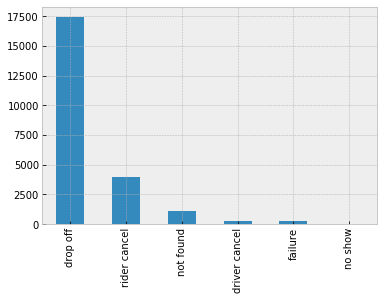

In [9]:
plt.style.use("bmh") 
df['end_state'].value_counts().plot.bar()

The graph above shows that most of the journeys ended with a drop off, so they were succesful in terms of driving a client from point A to point B. This end_state could help on filtering those journeys to be focus on the succesful information, while the journeys cancelled, not found or failure could be studied on a separate way. 

In [10]:
#Reducing the dataframe to the successful journeys

df_dp = df[(df['end_state'] == 'drop off')]
df_dp.head()

journey_id                           user_id  \
0  23a1406fc6a11d866e3c82f22eed4d4c  0e9af5bbf1edfe591b54ecdfd7e91e26   
4  85b7eabcf5d84e42dc7629b7d27781af  56772d544fdfa589a020a1ff894a86f7   
5  2254715f0f569e3173ec61f16cbb8341  56772d544fdfa589a020a1ff894a86f7   
6  12432d83b49393bf25164673212b8295  56772d544fdfa589a020a1ff894a86f7   
7  2e51db3a8a77aa594aa686ff19fe6036  56772d544fdfa589a020a1ff894a86f7   

                          driver_id                           taxi_id  \
0  583949a89a9ee17d19e3ca4f137b6b4c  b12f4f09c783e29fe0d0ea624530db56   
4  d665fb9f75ef5d9cd0fd89479380ba78  0accdd3aa5a322f4129fa20b53278c69   
5  baacf396f773709519bbde35a5eab861  baacf396f773709519bbde35a585d91b   
6  e1332f68e81526e498e4d845233a6d7d  e1332f68e81526e498e4d845235baf80   
7  d665fb9f75ef5d9cd0fd89479380ba78  0accdd3aa5a322f4129fa20b53278c69   

        icon start_type            start_at  start_lat  start_lon  \
0  executive       asap 2010-11-16 16:44:52 -12.139835 -77.023560   
4  executive   reserved 2010-09-11 23:55:00 -12.089954 -76.926270   
5  executive   reserved 2010-08-10 13:00:00 -12.022419 -77.106506   
6  executive   reserved 2010-08-08 12:10:00 -12.089958 -76.926208   
7  executive       asap 2010-05-16 03:58:59 -12.113472 -77.043854   

               end_at  ...  price_distance  price_duration distance  duration  \
0 2010-11-16 17:29:57  ...          3626.0           195.0  11331.0     234.0   
4 2010-09-12 01:07:02  ...          7665.0           562.0  30270.0     715.0   
5 2010-08-10 14:26:51  ...          7393.0          1001.0  29080.0    1201.0   
6 2010-08-08 12:48:02  ...          7112.0             0.0  27230.0       0.0   
7 2010-05-16 04:40:35  ...          5519.0           193.0  17247.0     232.0   

     cost cost_distance cost_duration  source  driver_score  rider_score  
0     0.0           0.0           0.0  iPhone           5.0          5.0  
4  6173.0        5756.0         417.0  iPhone           4.0          5.0  
5  5875.0        5175.0         700.0  iPhone           NaN          4.0  
6  5340.0        5340.0           0.0  iPhone           5.0          5.0  
7  4282.0        4139.0         143.0  iPhone           5.0          5.0  

[5 rows x 28 columns]

Once we have the reduced dataframe, now let's double check null values for other columns.

In [11]:
df_dp.isnull().sum()

journey_id             0
user_id                0
driver_id              0
taxi_id                0
icon                   0
start_type             0
start_at               0
start_lat              0
start_lon              0
end_at                 4
end_lat                0
end_lon                0
end_state              0
driver_start_lat     132
driver_start_lon     132
arrived_at             1
currency               0
price                  5
price_distance         1
price_duration         1
distance               0
duration               0
cost                 972
cost_distance       1874
cost_duration       1874
source                97
driver_score        9767
rider_score         2027
dtype: int64

For the journeys that ended on a drop off, there is no information for some records about where was the driver at the starting, neither cost (which maybe could be inferred from the price information) and the score is sometimes null too.

Let's explore about the start and end latitude and longitute to know where the journeys took place. The steps will be:
1. Create a dimension with latitude and longitude as string type (they are float) for the start and another for the end.
2. Import the module Nominatim from the library geopy to get the info.
3. Use the iterrows function to go through the dataframe and add the location info from geopy.


In [20]:
#Creating a start_location and a end_location column by concat start_lat and start lon as string types.
df_dp["start_location"] = df_dp["start_lat"].astype(str) + ',' + df_dp["start_lon"].astype(str)
df_dp["end_location"] = df_dp["end_lat"].astype(str) + ',' + df_dp["end_lon"].astype(str)

df_dp.head()

<ipython-input-20-2896aa24a6c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dp["start_location"] = df_dp["start_lat"].astype(str) + ',' + df_dp["start_lon"].astype(str)
<ipython-input-20-2896aa24a6c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dp["end_location"] = df_dp["end_lat"].astype(str) + ',' + df_dp["end_lon"].astype(str)


journey_id                           user_id  \
0  23a1406fc6a11d866e3c82f22eed4d4c  0e9af5bbf1edfe591b54ecdfd7e91e26   
4  85b7eabcf5d84e42dc7629b7d27781af  56772d544fdfa589a020a1ff894a86f7   
5  2254715f0f569e3173ec61f16cbb8341  56772d544fdfa589a020a1ff894a86f7   
6  12432d83b49393bf25164673212b8295  56772d544fdfa589a020a1ff894a86f7   
7  2e51db3a8a77aa594aa686ff19fe6036  56772d544fdfa589a020a1ff894a86f7   

                          driver_id                           taxi_id  \
0  583949a89a9ee17d19e3ca4f137b6b4c  b12f4f09c783e29fe0d0ea624530db56   
4  d665fb9f75ef5d9cd0fd89479380ba78  0accdd3aa5a322f4129fa20b53278c69   
5  baacf396f773709519bbde35a5eab861  baacf396f773709519bbde35a585d91b   
6  e1332f68e81526e498e4d845233a6d7d  e1332f68e81526e498e4d845235baf80   
7  d665fb9f75ef5d9cd0fd89479380ba78  0accdd3aa5a322f4129fa20b53278c69   

        icon start_type            start_at  start_lat  start_lon  \
0  executive       asap 2010-11-16 16:44:52 -12.139835 -77.023560   
4  executive   reserved 2010-09-11 23:55:00 -12.089954 -76.926270   
5  executive   reserved 2010-08-10 13:00:00 -12.022419 -77.106506   
6  executive   reserved 2010-08-08 12:10:00 -12.089958 -76.926208   
7  executive       asap 2010-05-16 03:58:59 -12.113472 -77.043854   

               end_at  ...    cost  cost_distance cost_duration  source  \
0 2010-11-16 17:29:57  ...     0.0            0.0           0.0  iPhone   
4 2010-09-12 01:07:02  ...  6173.0         5756.0         417.0  iPhone   
5 2010-08-10 14:26:51  ...  5875.0         5175.0         700.0  iPhone   
6 2010-08-08 12:48:02  ...  5340.0         5340.0           0.0  iPhone   
7 2010-05-16 04:40:35  ...  4282.0         4139.0         143.0  iPhone   

   driver_score rider_score                       start_location  \
0           5.0         5.0   -12.139835357666,-77.0235595703125   
4           4.0         5.0    -12.0899543762207,-76.92626953125   
5           NaN         4.0  -12.0224189758301,-77.1065063476562   
6           5.0         5.0   -12.089958190918,-76.9262084960938   
7           5.0         5.0  -12.1134719848633,-77.0438537597656   

   start_country  start_city                         end_location  
0           Perú  San Isidro  -12.0553703308106,-77.0413208007812  
4           Perú  San Isidro  -12.0222320556641,-77.1063842773438  
5           Perú  San Isidro  -12.0898017883301,-76.9260864257812  
6           Perú  San Isidro  -12.0215225219727,-77.1062316894531  
7           Perú  San Isidro  -12.0910873413086,-76.9226684570312  

[5 rows x 32 columns]

In [21]:
# initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")

In [22]:
#Running localiton for the dataframe

for index, row in df_dp.iterrows():
    df_dp['start_country'] = geolocator.reverse(row['start_location']).raw['address'].get('country', '')
    df_dp['start_city'] = geolocator.reverse(row['start_location']).raw['address'].get('city', '')
    df_dp['end_country'] = geolocator.reverse(row['end_location']).raw['address'].get('country', '')
    df_dp['end_city'] = geolocator.reverse(row['end_location']).raw['address'].get('city', '')
df_dp.head()

<ipython-input-22-960fd08471ae>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dp['start_country'] = geolocator.reverse(row['start_location']).raw['address'].get('country', '')
<ipython-input-22-960fd08471ae>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dp['start_city'] = geolocator.reverse(row['start_location']).raw['address'].get('city', '')
<ipython-input-22-960fd08471ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=-12.3915939331055&lon=-76.7866821289062&format=json&addressdetails=1 (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x7fbac8aaaee0>, 'Connection to nominatim.openstreetmap.org timed out. (connect timeout=1)'))

In [26]:
#Downloading the nurtured and reduced dataframe to csv in case of any errors, avoid the API nurture process again.
df_dp.to_csv('cabify_locat.csv')

## Explore different locations

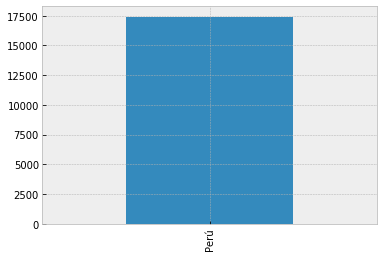

In [28]:
#Are there different countries for the starting?
plt.style.use("bmh") 
df_dp['start_country'].value_counts().plot.bar()

In [29]:
print('All the journeys took place in Perú.')

All the journeys took place in Perú.


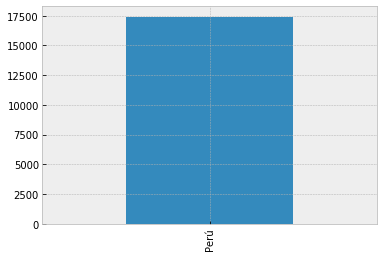

In [30]:
#Are there different countries for the ending?

df_dp['end_country'].value_counts().plot.bar()

In [31]:
print('All journeys finished in Perú, so all journeys were domestic.')

All journeys finished in Perú, so all journeys were domestic.


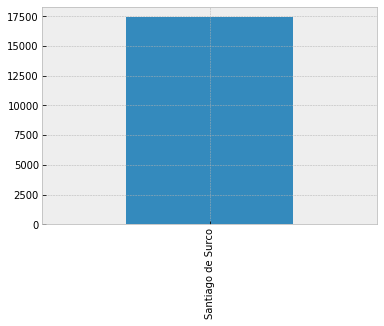

In [32]:
#Which are the different cities for startin?
df_dp['start_city'].value_counts().plot.bar()

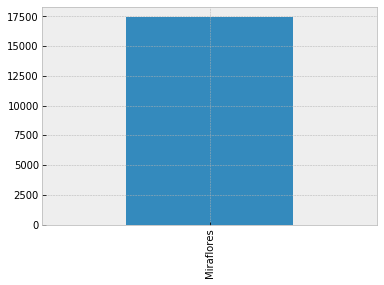

In [33]:
#Which are the different cities for ending?
df_dp['end_city'].value_counts().plot.bar()

In [48]:
print('All journeys started in Santiago de Surco and finished in Miraflores. Despite they seem different cities, they are two close areas in Lima.')

All journeys started in Santiago de Surco and finished in Miraflores. Despite they seem different cities, they are two close areas in Lima.


### Representing the map of starting journeys to know about the demand

Since the start_at records have no null values and thery are supposed to be from the year 2010, I fetched the month for starting the exploration at this level.

In [40]:
#Double checking there is only info for 2010

df_dp['start_at'].dt.year.value_counts()

2010    17417
Name: start_at, dtype: int64

In [41]:
print('All the records are related to 2010.')

All the records are related to 2010.


<ipython-input-42-4ee2e3ffc4f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dp['start_month'] = pd.to_datetime(df_dp['start_at'].values.astype('datetime64[M]'))


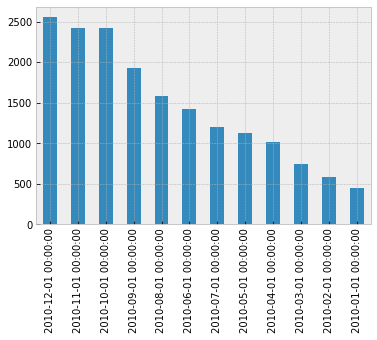

In [42]:
#Checking month information
df_dp['start_month'] = pd.to_datetime(df_dp['start_at'].values.astype('datetime64[M]'))
df_dp['start_month'].value_counts().plot.bar()

In [43]:
print('There is information for all months of the year and number of journeys were increasing during last Q of 2010.')

There is information for all months of the year and number of journeys were increasing during last Q of 2010.


For analyzing the demand in Santiago Surco and how the app could position its driver, I paint the information of starting journeys for December (the month with the highest demand) and July (one of the months with medium demand).

In [45]:
df_dp_dec = df_dp[(df_dp['start_month'] == '2010-12-01 00:00:00')]

<ipython-input-47-03ec0133a1e9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dp_dec['start_day'] = pd.to_datetime(df_dp_dec['start_at'].values.astype('datetime64[D]'))


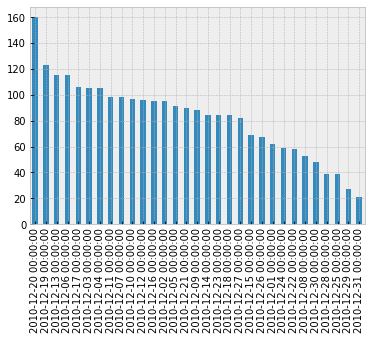

In [47]:
df_dp_dec['start_day'] = pd.to_datetime(df_dp_dec['start_at'].values.astype('datetime64[D]'))
df_dp_dec['start_day'].value_counts().plot.bar()

The december records show that the days with most demand were December, 20th, 19th and 13th maybe due to Christmas party because there are no bank holidays during those days. 

For having a better sense of the demand, I have included a breakdown by time: morning, afternoon, evening and night
Night: 00:00am - 06:00am
Morning: 06:00am - 12:00pm
Afternoon: 12:00pm - 17:00pm
Evening: 17:00pm - 22:00pm
Night: 22:00pm - 06:00am

In [71]:
#Truncating to hour
df_dp_dec['start_at'].astype('datetime64[ns]')
df_dp_dec['start_hour'] = df_dp_dec['start_at'].dt.hour


#binning times

df_dp_dec['time_range'] = np.where(df_dp_dec['start_hour']<6, 'night',
                        np.where(df_dp_dec['start_hour']<12, 'morning',
                        np.where(df_dp_dec['start_hour']<17, 'afternoon', 'evening')))

df_dp_dec.head()

<ipython-input-71-e3c1b0ebd6ba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dp_dec['start_hour'] = df_dp_dec['start_at'].dt.hour
<ipython-input-71-e3c1b0ebd6ba>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dp_dec['time_range'] = np.where(df_dp_dec['start_hour']<6, 'night',


journey_id                           user_id  \
10  297c055e30be8d9a933868c94980a7df  7abecd4f47c2c1d5390d86eb22181c90   
12  ea91d2d997d84fbfddbd2657db7bec90  39ec1ffa2e126b1691f97fef3e369d04   
13  ea91d2d997d84fbfddbd2657db7cad2e  39ec1ffa2e126b1691f97fef3e369d04   
28  80bac185b5571746a5985f7f0f32ba8b  297c055e30be8d9a933868c949b9bbac   
32  388cf395c282c2be29a124ced0dabde5  11b9c2d3923894404f5b4822af2257ad   

                           driver_id                           taxi_id  \
10  d04f1a596fe4a582f48e6eb2f9e8f617  d04f1a596fe4a582f48e6eb2f9e8cceb   
12  633dbc6b4e8edc3bf01b07b01ab543fe  275052e660ff5672db6624c42b67ef9c   
13  e84fda9c5df33f03c89b6923c361fb35  e84fda9c5df33f03c89b6923c362193f   
28  e1332f68e81526e498e4d845233a6d7d  e1332f68e81526e498e4d845235baf80   
32  e84fda9c5df33f03c89b6923c361fb35  e84fda9c5df33f03c89b6923c362193f   

         icon start_type            start_at  start_lat  start_lon  \
10  executive       asap 2010-12-14 03:08:18 -12.101429 -77.004341   
12  executive       asap 2010-12-14 22:39:15 -12.119957 -77.015338   
13  executive       asap 2010-12-14 19:23:09 -12.124917 -77.033675   
28  executive   reserved 2010-12-25 11:40:00 -12.114361 -77.041656   
32  executive       asap 2010-12-08 01:48:14 -12.117962 -77.011658   

                end_at  ...                       start_location  \
10 2010-12-14 03:39:09  ...  -12.1014294087981,-77.0043405890465   
12 2010-12-14 22:59:49  ...  -12.1199568147427,-77.0153383165598   
13 2010-12-14 20:00:24  ...  -12.1249167539688,-77.0336745679379   
28 2010-12-25 12:24:39  ...  -12.1143608093262,-77.0416564941406   
32 2010-12-08 02:21:00  ...  -12.1179618835449,-77.0116577148438   

    start_country         start_city                         end_location  \
10           Perú  Santiago de Surco  -12.1200810520042,-76.9952049851418   
12           Perú  Santiago de Surco  -12.1248180871192,-77.0336152240634   
13           Perú  Santiago de Surco  -12.1199551757283,-77.0152766257524   
28           Perú  Santiago de Surco  -12.0222587585449,-77.1075744628906   
32           Perú  Santiago de Surco  -12.1321105957031,-77.0301208496094   

    end_country    end_city start_month  start_day  start_hour  time_range  
10         Perú  Miraflores  2010-12-01 2010-12-14           3       night  
12         Perú  Miraflores  2010-12-01 2010-12-14          22     evening  
13         Perú  Miraflores  2010-12-01 2010-12-14          19     evening  
28         Perú  Miraflores  2010-12-01 2010-12-25          11     morning  
32         Perú  Miraflores  2010-12-01 2010-12-08           1       night  

[5 rows x 38 columns]

Other way for inferring the time range would be checking the price_distance for a specific distance and exploring the difference between the hours in the day. But I go with the numpy binning based on the proposal above.

For analyzing a high demand time, I reduce the dataframe to one of the 3 days of December with highest journeys and paint the map for each time range.

In [151]:
#Filtering the dataframe to Dec 19.
df_dp_dec_2 = df_dp_dec[(df_dp_dec['start_day'] == '2010-12-20')]

In [152]:
#Checking volumes for each time range for the whole month
pd.pivot_table(df_dp_dec_2, values = ['journey_id'],
                    columns=['time_range'], aggfunc=('size'))

time_range
afternoon    50
evening      55
morning      13
night        42
dtype: int64

In [153]:
#Plotting map

map_ = folium.Map(location=[df_dp_dec_2.iloc[0]['start_lat'], df_dp_dec_2.iloc[0]['start_lon']], 
                  tiles='OpenStreetMap',
                  zoom_start = 11)
map_

In [154]:
#Afternoon and evening journeys
df_dp_dec_2_m = df_dp_dec_2[(df_dp_dec_2['time_range'].isin(('afternoon', 'evening')))]


for index, row in df_dp_dec_2_m.iterrows():
    Marker((row['start_lat'], row['start_lon']),
           icon=folium.Icon(color='red')).add_to(map_)

In [155]:
#Morning and Night journeys
df_dp_dec_2_n = df_dp_dec_2[(df_dp_dec_2['time_range'].isin(('night', 'morning')))]


for index, row in df_dp_dec_2_n.iterrows():
    Marker((row['start_lat'], row['start_lon']),
           icon=folium.Icon(color='black')).add_to(map_)

In [156]:
#Plotting the map with the journeys
map_

### How many drivers were available during high demand days?

In [160]:
#Filtering dataframe to top days: 20th, 13th, 19th and 6th based on the above chart
df_dp_dec_3 = df_dp_dec[(df_dp_dec['start_day'].isin(('2010-12-19','2010-12-20','2010-12-13','2010-12-06')))]

pd.pivot_table(df_dp_dec_3, values = ['driver_id'], index=['start_day'],
                    columns=['time_range'], aggfunc=('size'))

time_range  afternoon  evening  morning  night
start_day                                     
2010-12-06         31       53        6     25
2010-12-13         41       40        8     26
2010-12-19         42       49        7     25
2010-12-20         50       55       13     42

In [175]:
df_dp_dec['driver_id'].unique().size

75

In [176]:
print('During December there were a total of 75 drivers available.')

During December there were a total of 75 drivers available.


<Figure size 1080x1080 with 0 Axes>

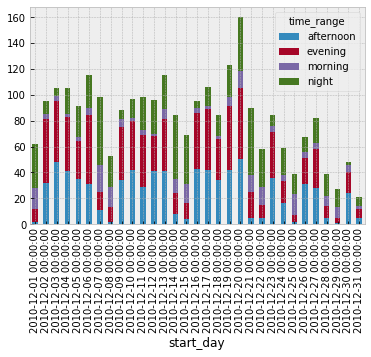

In [186]:
#How many drivers were available during December based on the time range?
plt.figure(figsize=(15,15))

pd.pivot_table(df_dp_dec, values = ['driver_id'], index=['start_day'],
                    columns=['time_range'], aggfunc=('size')).plot.bar(stacked=True)

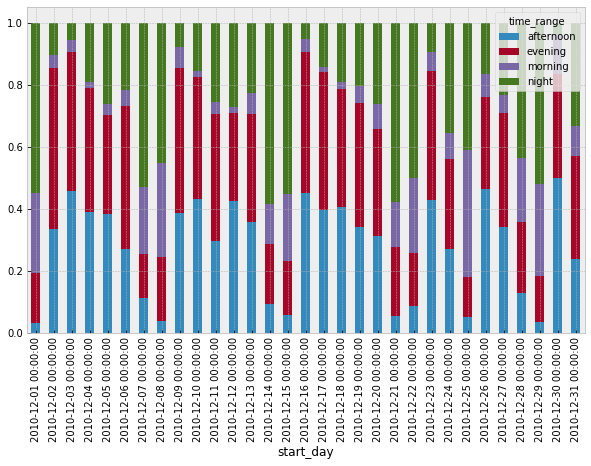

In [190]:
cross_tab = pd.crosstab(index=df_dp_dec['start_day'],
                        columns=df_dp_dec['time_range'],
                       normalize="index")

cross_tab.plot(kind='bar', 
                    stacked=True, 
                    figsize=(10, 6))

### When were journeys more profitable?

This analysis could be done in two ways:
1. Using just time range to when if the non-working hours were more profitable thant working hours.

2. Adding on top day of week to know if weekend had an impact on price.


Be aware that the app transfers up to 75% of the price to the driver, so the margin should be always ~25% of the price.

In [289]:
#For  quicker way, I go with the first option, using just time ranges.

#Calculating profit by the difference of price - cost (as first approach)

df_dp_dec['profit'] = df_dp_dec['price'].fillna(0) - df_dp_dec['cost'].fillna(0)
df_dp_dec.head()

<ipython-input-289-c835036d81ab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dp_dec['profit'] = df_dp_dec['price'].fillna(0) - df_dp_dec['cost'].fillna(0)


journey_id                           user_id  \
10  297c055e30be8d9a933868c94980a7df  7abecd4f47c2c1d5390d86eb22181c90   
12  ea91d2d997d84fbfddbd2657db7bec90  39ec1ffa2e126b1691f97fef3e369d04   
13  ea91d2d997d84fbfddbd2657db7cad2e  39ec1ffa2e126b1691f97fef3e369d04   
28  80bac185b5571746a5985f7f0f32ba8b  297c055e30be8d9a933868c949b9bbac   
32  388cf395c282c2be29a124ced0dabde5  11b9c2d3923894404f5b4822af2257ad   

                           driver_id                           taxi_id  \
10  d04f1a596fe4a582f48e6eb2f9e8f617  d04f1a596fe4a582f48e6eb2f9e8cceb   
12  633dbc6b4e8edc3bf01b07b01ab543fe  275052e660ff5672db6624c42b67ef9c   
13  e84fda9c5df33f03c89b6923c361fb35  e84fda9c5df33f03c89b6923c362193f   
28  e1332f68e81526e498e4d845233a6d7d  e1332f68e81526e498e4d845235baf80   
32  e84fda9c5df33f03c89b6923c361fb35  e84fda9c5df33f03c89b6923c362193f   

         icon start_type            start_at  start_lat  start_lon  \
10  executive       asap 2010-12-14 03:08:18 -12.101429 -77.004341   
12  executive       asap 2010-12-14 22:39:15 -12.119957 -77.015338   
13  executive       asap 2010-12-14 19:23:09 -12.124917 -77.033675   
28  executive   reserved 2010-12-25 11:40:00 -12.114361 -77.041656   
32  executive       asap 2010-12-08 01:48:14 -12.117962 -77.011658   

                end_at  ...  start_country         start_city  \
10 2010-12-14 03:39:09  ...           Perú  Santiago de Surco   
12 2010-12-14 22:59:49  ...           Perú  Santiago de Surco   
13 2010-12-14 20:00:24  ...           Perú  Santiago de Surco   
28 2010-12-25 12:24:39  ...           Perú  Santiago de Surco   
32 2010-12-08 02:21:00  ...           Perú  Santiago de Surco   

                           end_location  end_country    end_city start_month  \
10  -12.1200810520042,-76.9952049851418         Perú  Miraflores  2010-12-01   
12  -12.1248180871192,-77.0336152240634         Perú  Miraflores  2010-12-01   
13  -12.1199551757283,-77.0152766257524         Perú  Miraflores  2010-12-01   
28  -12.0222587585449,-77.1075744628906         Perú  Miraflores  2010-12-01   
32  -12.1321105957031,-77.0301208496094         Perú  Miraflores  2010-12-01   

    start_day  start_hour  time_range  profit  
10 2010-12-14           3       night   250.0  
12 2010-12-14          22     evening   250.0  
13 2010-12-14          19     evening   250.0  
28 2010-12-25          11     morning  1449.0  
32 2010-12-08           1       night   250.0  

[5 rows x 39 columns]

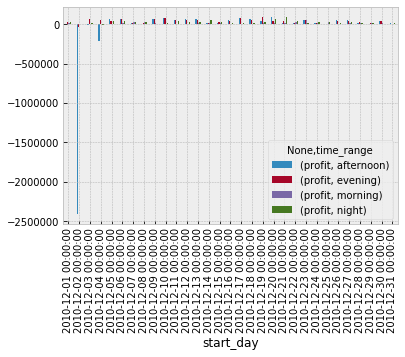

In [268]:
pd.pivot_table(df_dp_dec, values = ['profit'], index=['start_day'],
                    columns=['time_range'], aggfunc=('sum')).plot.bar()

The chart shows that there were a couple of days with negative profit. Let's explore them.

In [269]:
df_dp_dec_np = df_dp_dec[((df_dp_dec['start_day'] == '2010-12-02') & (df_dp_dec['profit'] < 0))]
df_dp_dec_np.head()

journey_id                           user_id  \
4164   904ecef1a023a13521a66deb525f7d6a  86aa09456b63a2a25e0097c55203cb59   
4170   12e83984f1fe2256322789e43b735c7c  d7a314341b76460d7b4aa4c0cdc429ad   
4206   ae38852535ddc0db175151356bef02e6  d714d3665aaaf6f748ce2d52f48b4321   
10548  904ecef1a023a13521a66deb52adfcfc  c6edbfc4eedf3b9eccc4df5f1b2da11a   
10549  904ecef1a023a13521a66deb52ac9b39  59a766bd488db1053eeba5a3aea922df   

                              driver_id                           taxi_id  \
4164   6e168888d1ec73590b7ea371548757b5  2a7979f6826bbbf4a061456c47623b7c   
4170   ae06c34243f741e203e97c48ebcbd9da  f622a9397b85b5c9c0ef938c5d592020   
4206   633dbc6b4e8edc3bf01b07b01ab543fe  275052e660ff5672db6624c42b67ef9c   
10548  ecdcce0c956e266ed26c80fd9e5cbb8f  1d3c551d7fc3d0daf73f0a8c82781c2d   
10549  ecdcce0c956e266ed26c80fd9e1c188c  ecdcce0c956e266ed26c80fd9e7ec7e8   

            icon start_type            start_at  start_lat  start_lon  \
4164   executive   reserved 2010-12-02 14:00:00 -12.105110 -77.045593   
4170   executive   reserved 2010-12-02 16:35:00 -12.093277 -77.027544   
4206   executive   reserved 2010-12-02 18:40:00 -12.093185 -77.024780   
10548  executive   reserved 2010-12-02 13:20:00 -12.100968 -77.058676   
10549  executive   reserved 2010-12-02 23:00:00 -12.081114 -76.976677   

                   end_at  ...  start_country         start_city  \
4164  2010-12-02 14:52:54  ...           Perú  Santiago de Surco   
4170  2010-12-02 17:02:34  ...           Perú  Santiago de Surco   
4206  2010-12-02 18:47:08  ...           Perú  Santiago de Surco   
10548 2010-12-02 13:35:51  ...           Perú  Santiago de Surco   
10549 2010-12-02 23:37:52  ...           Perú  Santiago de Surco   

                              end_location  end_country    end_city  \
4164   -12.0866317749023,-76.9913024902344         Perú  Miraflores   
4170    -12.104168050019,-76.9728115573525         Perú  Miraflores   
4206   -12.0982246398926,-77.0420837402344         Perú  Miraflores   
10548  -12.1191963109837,-77.0275259390473         Perú  Miraflores   
10549  -12.0776131280391,-76.9397100806236         Perú  Miraflores   

      start_month  start_day  start_hour  time_range    profit  
4164   2010-12-01 2010-12-02          14   afternoon -352338.0  
4170   2010-12-01 2010-12-02          16   afternoon -276715.0  
4206   2010-12-01 2010-12-02          18     evening  -30800.0  
10548  2010-12-01 2010-12-02          13   afternoon -101300.0  
10549  2010-12-01 2010-12-02          23     evening  -77682.0  

[5 rows x 39 columns]

Exploring why there was so much negative profit and if it was related to some drivers or if the score could clarify something or maybe if it's impacted by a promotion.

In [270]:
df_dp_dec_np['driver_id'].nunique()

16

In [271]:
df_dp_dec[(df_dp_dec['start_day'] == '2010-12-02')]['driver_id'].nunique()

29

In [272]:
print('There was 16 drivers related to negative profit out of 29 available drivers on December, 2nd.')

There was 16 drivers related to negative profit out of 29 available drivers on December, 2nd.


In [202]:
#If there is score information for the driver, which was it for those negative profit journeys?

df_dp_dec_np['driver_score'].value_counts()

5.0    4
4.0    2
3.0    1
Name: driver_score, dtype: int64

In [204]:
print('7 of 16 journeys were scored with more than 3 points, so there couldnt be a problem with most of the drivers. Maybe there was a promo or an issue with the app. For knowing if there was a promo we should check ERP info to know if at an invoicing level there was it.')

7 of 16 journeys were scored with more than 3 points, so there couldnt be a problem with most of the drivers. Maybe there was a promo or an issue with the app. For knowing if there was a promo we should check ERP info to know if at an invoicing level there was it.


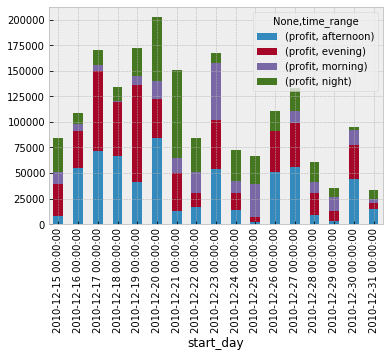

In [273]:
#Avoiding negative profit days by filtering the dataframe to last 15 days of December and visualizting the profit again

df_dp_dec15 = df_dp_dec[(df_dp_dec['start_day'] > '2010-12-14')]

pd.pivot_table(df_dp_dec15, values = ['profit'], index=['start_day'],
                    columns=['time_range'], aggfunc=('sum')).plot.bar(stacked=True)

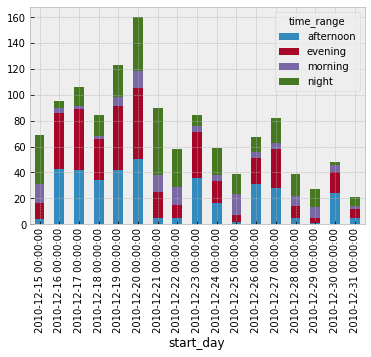

In [274]:
#Checking journeys volume to cross with profit
pd.pivot_table(df_dp_dec15, values = ['journey_id'], index=['start_day'],
                    columns=['time_range'], aggfunc=('size')).plot.bar(stacked=True)

In [275]:
#Plotting journeys and profit together
agg_jp = df_dp_dec15.groupby(['start_day']).agg({'journey_id': ['size'],'profit': ['sum']})
agg_jp

journey_id    profit
                 size       sum
start_day                      
2010-12-15         69   83861.0
2010-12-16         95  108280.0
2010-12-17        106  170122.0
2010-12-18         84  133998.0
2010-12-19        123  172328.0
2010-12-20        160  202387.0
2010-12-21         90  150919.0
2010-12-22         58   84154.0
2010-12-23         84  167513.0
2010-12-24         59   72628.0
2010-12-25         39   66551.0
2010-12-26         67  110195.0
2010-12-27         82  133153.0
2010-12-28         39   60755.0
2010-12-29         27   35760.0
2010-12-30         48   95013.0
2010-12-31         21   33742.0

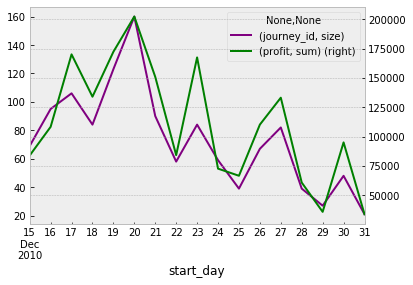

In [276]:
ax = df_dp_dec15.groupby(['start_day']).agg({'journey_id': ['size']}).plot(kind='line',color='purple')

ax2 = df_dp_dec15.groupby(['start_day']).agg({'profit': ['sum']}).plot(kind='line',color='green', secondary_y = True, ax = ax)

### New approach for profit Using the 25% of price

In [290]:
#Secon approach for profit. Using theoretical profit as 25% of price

df_dp_dec['theoretical_profit'] = df_dp_dec['price'].fillna(0) * 0.25
df_dp_dec.head()

<ipython-input-290-f5e92fb5e3fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dp_dec['theoretical_profit'] = df_dp_dec['price'].fillna(0) * 0.25


journey_id                           user_id  \
10  297c055e30be8d9a933868c94980a7df  7abecd4f47c2c1d5390d86eb22181c90   
12  ea91d2d997d84fbfddbd2657db7bec90  39ec1ffa2e126b1691f97fef3e369d04   
13  ea91d2d997d84fbfddbd2657db7cad2e  39ec1ffa2e126b1691f97fef3e369d04   
28  80bac185b5571746a5985f7f0f32ba8b  297c055e30be8d9a933868c949b9bbac   
32  388cf395c282c2be29a124ced0dabde5  11b9c2d3923894404f5b4822af2257ad   

                           driver_id                           taxi_id  \
10  d04f1a596fe4a582f48e6eb2f9e8f617  d04f1a596fe4a582f48e6eb2f9e8cceb   
12  633dbc6b4e8edc3bf01b07b01ab543fe  275052e660ff5672db6624c42b67ef9c   
13  e84fda9c5df33f03c89b6923c361fb35  e84fda9c5df33f03c89b6923c362193f   
28  e1332f68e81526e498e4d845233a6d7d  e1332f68e81526e498e4d845235baf80   
32  e84fda9c5df33f03c89b6923c361fb35  e84fda9c5df33f03c89b6923c362193f   

         icon start_type            start_at  start_lat  start_lon  \
10  executive       asap 2010-12-14 03:08:18 -12.101429 -77.004341   
12  executive       asap 2010-12-14 22:39:15 -12.119957 -77.015338   
13  executive       asap 2010-12-14 19:23:09 -12.124917 -77.033675   
28  executive   reserved 2010-12-25 11:40:00 -12.114361 -77.041656   
32  executive       asap 2010-12-08 01:48:14 -12.117962 -77.011658   

                end_at  ...         start_city  \
10 2010-12-14 03:39:09  ...  Santiago de Surco   
12 2010-12-14 22:59:49  ...  Santiago de Surco   
13 2010-12-14 20:00:24  ...  Santiago de Surco   
28 2010-12-25 12:24:39  ...  Santiago de Surco   
32 2010-12-08 02:21:00  ...  Santiago de Surco   

                           end_location end_country    end_city  start_month  \
10  -12.1200810520042,-76.9952049851418        Perú  Miraflores   2010-12-01   
12  -12.1248180871192,-77.0336152240634        Perú  Miraflores   2010-12-01   
13  -12.1199551757283,-77.0152766257524        Perú  Miraflores   2010-12-01   
28  -12.0222587585449,-77.1075744628906        Perú  Miraflores   2010-12-01   
32  -12.1321105957031,-77.0301208496094        Perú  Miraflores   2010-12-01   

    start_day start_hour  time_range  profit  theoretical_profit  
10 2010-12-14          3       night   250.0               425.0  
12 2010-12-14         22     evening   250.0               425.0  
13 2010-12-14         19     evening   250.0               425.0  
28 2010-12-25         11     morning  1449.0              1440.5  
32 2010-12-08          1       night   250.0               425.0  

[5 rows x 40 columns]

In [292]:
#Replicating profit and theoretical profit for all drop-off journeys to know more about the profit and theoretical profit

df_dp['theoretical_profit'] = df_dp['price'].fillna(0) * 0.25


<ipython-input-292-6a7284b6a269>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dp['theoretical_profit'] = df_dp['price'].fillna(0) * 0.25


journey_id                           user_id  \
0  23a1406fc6a11d866e3c82f22eed4d4c  0e9af5bbf1edfe591b54ecdfd7e91e26   
4  85b7eabcf5d84e42dc7629b7d27781af  56772d544fdfa589a020a1ff894a86f7   
5  2254715f0f569e3173ec61f16cbb8341  56772d544fdfa589a020a1ff894a86f7   
6  12432d83b49393bf25164673212b8295  56772d544fdfa589a020a1ff894a86f7   
7  2e51db3a8a77aa594aa686ff19fe6036  56772d544fdfa589a020a1ff894a86f7   

                          driver_id                           taxi_id  \
0  583949a89a9ee17d19e3ca4f137b6b4c  b12f4f09c783e29fe0d0ea624530db56   
4  d665fb9f75ef5d9cd0fd89479380ba78  0accdd3aa5a322f4129fa20b53278c69   
5  baacf396f773709519bbde35a5eab861  baacf396f773709519bbde35a585d91b   
6  e1332f68e81526e498e4d845233a6d7d  e1332f68e81526e498e4d845235baf80   
7  d665fb9f75ef5d9cd0fd89479380ba78  0accdd3aa5a322f4129fa20b53278c69   

        icon start_type            start_at  start_lat  start_lon  \
0  executive       asap 2010-11-16 16:44:52 -12.139835 -77.023560   
4  executive   reserved 2010-09-11 23:55:00 -12.089954 -76.926270   
5  executive   reserved 2010-08-10 13:00:00 -12.022419 -77.106506   
6  executive   reserved 2010-08-08 12:10:00 -12.089958 -76.926208   
7  executive       asap 2010-05-16 03:58:59 -12.113472 -77.043854   

               end_at  ...                       start_location  \
0 2010-11-16 17:29:57  ...   -12.139835357666,-77.0235595703125   
4 2010-09-12 01:07:02  ...    -12.0899543762207,-76.92626953125   
5 2010-08-10 14:26:51  ...  -12.0224189758301,-77.1065063476562   
6 2010-08-08 12:48:02  ...   -12.089958190918,-76.9262084960938   
7 2010-05-16 04:40:35  ...  -12.1134719848633,-77.0438537597656   

   start_country         start_city                         end_location  \
0           Perú  Santiago de Surco  -12.0553703308106,-77.0413208007812   
4           Perú  Santiago de Surco  -12.0222320556641,-77.1063842773438   
5           Perú  Santiago de Surco  -12.0898017883301,-76.9260864257812   
6           Perú  Santiago de Surco  -12.0215225219727,-77.1062316894531   
7           Perú  Santiago de Surco  -12.0910873413086,-76.9226684570312   

   end_country    end_city start_month  start_day  profit  theoretical_profit  
0         Perú  Miraflores  2010-11-01 2010-11-16  3821.0              955.25  
4         Perú  Miraflores  2010-09-01 2010-09-11  2054.0             2056.75  
5         Perú  Miraflores  2010-08-01 2010-08-10  2519.0             2098.50  
6         Perú  Miraflores  2010-08-01 2010-08-08  1772.0             1778.00  
7         Perú  Miraflores  2010-05-01 2010-05-16  1430.0             1428.00  

[5 rows x 38 columns]

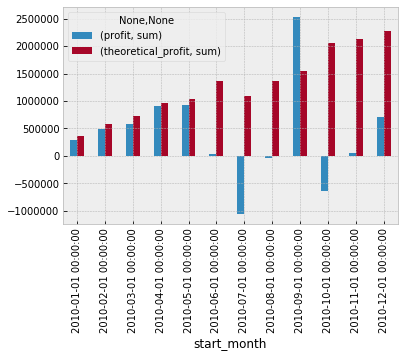

In [295]:
#Visualizing profit and theoretical profit by month

agg_dp = df_dp.groupby(['start_month']).agg({'profit': ['sum'],'theoretical_profit': ['sum']})
agg_dp.plot.bar()

During the five first months of the year profit and theoretical profit were pretty similar. But from June on there were a couple of months with high difference on total for profit and theoretical profit. This could be due to promotions or voucher, difference on routes (changes on the way), traffic or other issues.

Maybe there is a difference between price (as the estimated price showed to the client and the final price). 

### Checking the number of journeys, profit and theoretical profit by user

In order to know if the first journey of the user is having a promo impacting the profit, let see the number of journeys by user and if users having more volume have less profit or not.

In [312]:
agg_users = df_dp.groupby(['user_id']).agg({'journey_id': ['size'],'profit': ['sum'],'theoretical_profit': ['sum']})
agg_users.sort_values(by=[('journey_id', 'size')], ascending=True).head(50)

journey_id    profit theoretical_profit
                                       size       sum                sum
user_id                                                                 
883360491194dd3b866c897b258c7d38          1    3210.0             802.50
837f1b20121093bdceefd102a8632ab9          1    2919.0             729.75
837f1b20121093bdceefd102a86785f0          1     357.0             514.25
837fafe7c928dce2d591f2b10227da8a          1    2852.0             713.00
85a5e7c05506fa2e6ec863f6fef80462          1     465.0             541.25
85b7eabcf5d84e42dc7629b7d2f4f971          1    1700.0             425.00
86aa09456b63a2a25e0097c55203a342          1    3113.0             778.25
833db84f4d006a7dc159fa44da2170a7          1    1740.0            1740.75
883360491194dd3b866c897b258d161e          1    5810.0            1452.50
885cdc2c091912b6fed0425a9c0c25ca          1    1397.0            1396.75
8ba4a81c021a667d4bf75dd45d45262f          1    1969.0            1961.50
8c698ef7e29e08fb068553178dd97f65          1    1700.0             425.00
8ff94ac5183d99dc41b042ad5cd72c51          1     120.0             455.00
91ace458f877ac65d28e93559c6943bc          1    1700.0             425.00
922d998685f68f17dd0f3c9f36de78f2          1    3596.0             899.00
8842ece0c6fb65eb4499f76c51cea1b7          1    1217.0            1214.00
936bb760a34c2bcf7c6da25cee7a662a          1     250.0             425.00
81909d34a4420a253a42ce5cdcbcb0f2          1    1382.0            1151.50
81909d34a4420a253a42ce5cdc524a2e          1     269.0             492.25
75f83a9faa738dfb5e1c8955920e4f78          1     989.0             824.00
760cafde3f1d33ceca82940e5230949c          1     488.0             547.00
784a730957c6e05508e71c604ace5ada          1    1562.0            1548.75
78851a91f305d3ed7bb3cc0111de403d          1    1082.0            1078.75
79491ba0ccd4f701b116e4ac3ee5ac2e          1     699.0             581.75
7b894f8002c2ab22f7c385ddb3cb289a          1    2078.0            2074.50
81909d34a4420a253a42ce5cdcb7aa74          1    1990.0            1983.50
7d1f317a98447453092aa1301eb528ef          1     564.0             566.00
7e9ffcfa6264bf3de3135ba5ab6988db          1    1540.0            1560.25
7e9ffcfa6264bf3de3135ba5ab6b8e2a          1     609.0             607.00
807f274d7a99210e52857364d84df0a1          1     938.0             782.00
807f274d7a99210e52857364d8cd8b45          1    2901.0            2418.00
80bac185b5571746a5985f7f0f3391ca          1    2691.0             672.75
81909d34a4420a253a42ce5cdc51cf11          1    1700.0             425.00
7e42278dac68e36c0cf829e1d8d8e9d0          1     198.0             474.50
93b4c8d3bdfd931a266ea99f7955834a          1    4583.0            1145.75
9448070ece760ea5386e5d4822db1c35          1     250.0             425.00
9448070ece760ea5386e5d4822ffcb25          1     289.0             434.75
a59005aea23d440a2e31b8c1dac9645c          1    1700.0             425.00
a668e2e4650c5abe20e4db4ae07cd3e8          1     892.0             743.50
a668e2e4650c5abe20e4db4ae0bb2d87          1    2040.0             510.00
a69cc3b72d1e83faa28f4bd927fdf32d          1     260.0             490.00
a6d2256140cd16b2b9d85052b3715824          1    1133.0            1131.25
a6d2256140cd16b2b9d85052b3b0780b          1     250.0             425.00
a553c46e3a22fb9c326aeb3d7273679c          1       0.0             425.00
a75e7b07b437bc6b83f1073cfe360596          1     756.0             755.50
a7a9c80cb98e69abb854996421afc258          1     732.0             729.00
a80b8e14030b5d1e76d59fffbf21b9bf          1 -136820.0            1045.00
a82e1fee7fdfef84c33687409f9ef319          1     911.0             908.00
a89e50234bb6c1a61101ba24c41de0e3          1     925.0             918.50
a92faa0a8fe8d690b29dcaac2d70656a          1    1446.0            1449.00

Showing a sample of clients with just 1 journey, we could see that most of them have positive profit which means that the first journey is not impacted by a promo.

In [313]:
agg_users.sort_values(by=[('journey_id', 'size')], ascending=False)

journey_id     profit theoretical_profit
                                       size        sum                sum
user_id                                                                  
ae06c34243f741e203e97c48eb42017b        447  -703118.0          309796.00
a86c8d399be95a32f795a8a9887127b9        434   524069.0          249879.00
8ed36e0e9dbf62743c06c09e5f7c1835        416  -418992.0          205571.75
8e37a68fab5f31a5e2c1b5f77c6bb9e5        375    95574.0          366175.75
406921adcca37705ef527b4246c12e83        343   364919.0          301395.00
0a98cead98f3935ef3051e834a30419e        337   863634.0          918705.25
ae06c34243f741e203e97c48eb62c195        311   255354.0          159197.25
ae06c34243f741e203e97c48eb62e6db        254   283213.0          154228.25
55a921582f7b88ef61a3d8e24f502205        246  -382446.0          137206.25
4c37542f88f6bc6fb2465a93be210506        245    67800.0          185792.75
65b6f3b7075270499ddd0f1dc10f9ac6        243   164589.0          136262.25
d2f1475850c213560abdec5deae2dc97        237   409441.0          311889.75
ca5f041e0b807120714a6e4616154d37        218   163772.0          128077.75
cf3a94138caddceb3209e4723638ef6f        210    10247.0          201219.25
2ca81f8112b8c60af222ee2ed7287d4e        193   118772.0          132611.75
406921adcca37705ef527b4246c1370e        188   127373.0          130843.00
13cd660fbea6e3b6221aa0fc6fcb8f58        175   147005.0          144648.50
27bd69801ce062f9b751502b38443d94        170   159337.0           97875.75
699c76a8203348961730e0164a753a25        160   173732.0           82591.75
ded01e648ddbeb109e0b377479b816be        160   147827.0          114336.50
86aa09456b63a2a25e0097c55203cb59        158  -407837.0          120175.25
9b474537c2b26020bb16aee19acacccf        156   109689.0          121937.00
59a766bd488db1053eeba5a3aea922df        152  -334901.0          105889.00
e4cae9e711f3aa4ce90ed98f2817e733        115   166086.0           77610.00
b8329294de68c83ec04d2edab5f52e3f        115    74458.0           65695.00
760cafde3f1d33ceca82940e5230f9af        113   150639.0          110370.75
8d7a255716cbbbbf448c696c69370f2d        113    33206.0           83061.75
15c2795f9994744f8ffef0a4ba095708        106   -39711.0           67792.75
caa7a1b7f11b99895d9991c3635fd51d        104   150361.0          102565.50
68fe4d0ad82cc2d715d131953312673c        100   101590.0           65568.00
e4cae9e711f3aa4ce90ed98f28380df7         94    45977.0           54416.50
851e424ed81e136e7e8c4b9ab0a84dd9         94   125626.0           95808.25
86aa09456b63a2a25e0097c55220cd9a         93   202929.0          100986.25
f78d50ea4f0c83a4a302d9fa8220c654         93   -31469.0           64131.25
e1332f68e81526e498e4d84523390d76         93    98501.0           46290.00
3546db06867c6c6f85e353c8ea633d07         89    31203.0           44535.25
85beef0c795e5e4cacf4aa4058c16b01         87    39968.0           64918.25
b8ae7685c97ef64f90a646a3b97e4233         85   141031.0          106793.75
b7dea45c3cc92b9efd5a4905e69fa8a1         81   103125.0           79855.25
86aa09456b63a2a25e0097c5520497ec         75  -644856.0          115576.75
5d3f4707b95580ea79778ab1c3eea390         75  -442297.0           51383.75
81391eb34b4ff58d304e5aa357d4c7df         74   -50361.0           56767.50
68fe4d0ad82cc2d715d131953336d717         71    69875.0           45359.50
16cbe35db7fff70fbc8251b4cdc843b1         71   155653.0          123390.25
a479cdd4f9c8127e0f521fdf5d7a7fa0         71    79878.0           48495.50
851e424ed81e136e7e8c4b9ab0a89e94         66    66659.0           38926.75
576d6a494b4a0c632e3f088675ca677b         65    70434.0           36984.50
e84fda9c5df33f03c89b6923c3650564         64    54656.0           33694.25
649d38ea6680a3f6ee4a4b734f7898bf         63  -202362.0           38082.75
baacf396f773709519bbde35a587f7f4         62  -144718.0          166182.75
88a0d8a123b3c1b2f39bec89da5567a1         59    58882.0           38544.25
9a509746b5612ec4d3126dab574b4c84     

When sorting clients by the number of journeys during 2010, the aggregated table showed that users with the highest volume of journeys also have high negative profit. Since there is no info for revenue neither real cost is quite difficult to drive conclussions from here, to know where is coming this profit gap from.

### Investigating about how the negative profit evolves during 2010 related to journeys

To know a bit more about the amount of negative profit related to the journeys, let's check the percentage of journeys with negative profit.

In [314]:
df_dp.head()

journey_id                           user_id  \
0  23a1406fc6a11d866e3c82f22eed4d4c  0e9af5bbf1edfe591b54ecdfd7e91e26   
4  85b7eabcf5d84e42dc7629b7d27781af  56772d544fdfa589a020a1ff894a86f7   
5  2254715f0f569e3173ec61f16cbb8341  56772d544fdfa589a020a1ff894a86f7   
6  12432d83b49393bf25164673212b8295  56772d544fdfa589a020a1ff894a86f7   
7  2e51db3a8a77aa594aa686ff19fe6036  56772d544fdfa589a020a1ff894a86f7   

                          driver_id                           taxi_id  \
0  583949a89a9ee17d19e3ca4f137b6b4c  b12f4f09c783e29fe0d0ea624530db56   
4  d665fb9f75ef5d9cd0fd89479380ba78  0accdd3aa5a322f4129fa20b53278c69   
5  baacf396f773709519bbde35a5eab861  baacf396f773709519bbde35a585d91b   
6  e1332f68e81526e498e4d845233a6d7d  e1332f68e81526e498e4d845235baf80   
7  d665fb9f75ef5d9cd0fd89479380ba78  0accdd3aa5a322f4129fa20b53278c69   

        icon start_type            start_at  start_lat  start_lon  \
0  executive       asap 2010-11-16 16:44:52 -12.139835 -77.023560   
4  executive   reserved 2010-09-11 23:55:00 -12.089954 -76.926270   
5  executive   reserved 2010-08-10 13:00:00 -12.022419 -77.106506   
6  executive   reserved 2010-08-08 12:10:00 -12.089958 -76.926208   
7  executive       asap 2010-05-16 03:58:59 -12.113472 -77.043854   

               end_at  ...                       start_location  \
0 2010-11-16 17:29:57  ...   -12.139835357666,-77.0235595703125   
4 2010-09-12 01:07:02  ...    -12.0899543762207,-76.92626953125   
5 2010-08-10 14:26:51  ...  -12.0224189758301,-77.1065063476562   
6 2010-08-08 12:48:02  ...   -12.089958190918,-76.9262084960938   
7 2010-05-16 04:40:35  ...  -12.1134719848633,-77.0438537597656   

   start_country         start_city                         end_location  \
0           Perú  Santiago de Surco  -12.0553703308106,-77.0413208007812   
4           Perú  Santiago de Surco  -12.0222320556641,-77.1063842773438   
5           Perú  Santiago de Surco  -12.0898017883301,-76.9260864257812   
6           Perú  Santiago de Surco  -12.0215225219727,-77.1062316894531   
7           Perú  Santiago de Surco  -12.0910873413086,-76.9226684570312   

   end_country    end_city start_month  start_day  profit  theoretical_profit  
0         Perú  Miraflores  2010-11-01 2010-11-16  3821.0              955.25  
4         Perú  Miraflores  2010-09-01 2010-09-11  2054.0             2056.75  
5         Perú  Miraflores  2010-08-01 2010-08-10  2519.0             2098.50  
6         Perú  Miraflores  2010-08-01 2010-08-08  1772.0             1778.00  
7         Perú  Miraflores  2010-05-01 2010-05-16  1430.0             1428.00  

[5 rows x 38 columns]

In [320]:
df_dp_np = df_dp[(df_dp['profit'] < 0)]
df_dp_np.groupby(['start_month']).agg({'journey_id': ['size'],'profit': ['sum']})

journey_id     profit
                  size        sum
start_month                      
2010-01-01          89    -6772.0
2010-02-01          54   -14542.0
2010-03-01          40   -11789.0
2010-04-01           1    -1569.0
2010-05-01           9   -16920.0
2010-06-01          19 -2650372.0
2010-07-01          20 -3480114.0
2010-08-01          24 -2655613.0
2010-09-01           3  -142089.0
2010-10-01          39 -4206906.0
2010-11-01          32 -3461469.0
2010-12-01          28 -3120221.0

The volume of journeys with negative profit hasn't increased during 2010 while the negative profit did.


So there should be some clients, taxis or journeys that were more expensive.

In [325]:
## Exploring if the taxi or driver is the cause by counting the volume of journeys with negative profit by taxi and driver

df_dp_np.groupby(['taxi_id']).agg({'journey_id': ['size'],'profit': ['sum']}).sort_values(by=[('profit', 'sum')], ascending=True)

journey_id     profit
                                       size        sum
taxi_id                                               
16cbe35db7fff70fbc8251b4cdca8eb8          7 -2379007.0
16cbe35db7fff70fbc8251b4cdcccb70          6 -2272666.0
16cbe35db7fff70fbc8251b4cda9fdc9          5 -1820873.0
16cbe35db7fff70fbc8251b4cdaa06cb          5 -1415747.0
c2ed6bdd0113ad6f195e8586932279ba          6 -1229391.0
35a17a45aa341b999787fa5e50608f65          4 -1164550.0
16cbe35db7fff70fbc8251b4cdaa037d          3 -1052839.0
ff5c924e0b630fd7c019a423405c86f6         14 -1011061.0
fdd18304908a4fa34b8435f2646224bd          4  -868038.0
f622a9397b85b5c9c0ef938c5d592020          4  -659946.0
c814db2127582cf95dea1f74f4310a9b         17  -428709.0
2a7979f6826bbbf4a061456c47623b7c          1  -352338.0
f6254a51b033dcea52c37c715b010474          1  -351644.0
ab6ee368af1a9e1293acc0d14d1f9338          2  -208281.0
b12f4f09c783e29fe0d0ea624530db56          2  -201145.0
ab6ee368af1a9e1293acc0d14d86f061          1  -200656.0
922d998685f68f17dd0f3c9f36dd51ac          2  -188888.0
19ab0c811749e07944b0deccb507767e          2  -188577.0
716a697375634f32a06d692b0448f13d          1  -186577.0
0aa51cbf1d21c8c6462dbf0e10027148          3  -173118.0
395884c1271e80e946d1f02dd92d61c5          2  -166517.0
992347d5c59f47b13b14442c6d4dd2fd          2  -163300.0
f6d984387f19e8b2adf9550ee82502bb          2  -158757.0
ab581e277813d5d9ff98d03b1c761722         19  -158329.0
bb1e39070cf5a2e2390f00f990d754c9          3  -152273.0
d04f1a596fe4a582f48e6eb2f9e8cceb         27  -137954.0
fdd18304908a4fa34b8435f2646221f9          1  -136820.0
eef4aeee867d60d44e1d077d1605292e          2  -129328.0
b66c43e298753a3d39220e53008a4f19          3  -125503.0
b12f4f09c783e29fe0d0ea62452b9347          3  -125349.0
992347d5c59f47b13b14442c6daca5ac          1  -123803.0
294e869d187357cad25b8af65aa860e8         13  -119116.0
1d3c551d7fc3d0daf73f0a8c82781c2d          2  -111744.0
fdd18304908a4fa34b8435f2646212b8          2  -104573.0
78851a91f305d3ed7bb3cc0111e343e2          2  -101993.0
684e09fb0761605e25d148f3d3105517          1  -100447.0
c31d580a863a6601a97b1b12898445d4          6   -98910.0
6e82410a7a2444e1199e6adb2f5c405b          2   -97784.0
924d4f0e7554566623e8ebb3904a7b0c          6   -94030.0
fb81277200c0aea311ad85f90d733b00          5   -90064.0
ecdcce0c956e266ed26c80fd9e7ec7e8          2   -86541.0
395884c1271e80e946d1f02dd950b67e          2   -73347.0
78851a91f305d3ed7bb3cc0111e35154          2   -55516.0
ba102ab81aaae9437a473f04c2656149          3   -48672.0
ccfcfc81abe6485b505ba742749ab3fe          1   -45466.0
ecad23449871b9851b3730d0b3a50cd6          1   -41414.0
684e09fb0761605e25d148f3d30e2a2e          1   -40146.0
62f21a3c31604c1907882fafee98e804          1   -34300.0
19ab0c811749e07944b0deccb507d16f          2   -33434.0
fdd18304908a4fa34b8435f264620c40          1   -31902.0
87586ba0f6d5a6b3999c9e4e412a4a25          1   -31800.0
275052e660ff5672db6624c42b67ef9c          1   -30800.0
593ae49af455f324457edc1472aed026          3   -25311.0
fa5c3d1ad73379ba86b960210e63ee78          1   -24106.0
57b7491a7db5ce935f85855c193b0f4d          1   -21300.0
e84fda9c5df33f03c89b6923c362193f          2   -21128.0
1d8ba0bdacccf2d0d70ee99251862c54          1   -20182.0
d2f1475850c213560abdec5deae0e32c          2   -19462.0
18f48f18ba313b30f2849a5c0af80ac2          1   -19401.0
bd614a1e34c36eb416c2fb88655c5939          1   -19300.0
62c2e39787aa19cd2513901cf3b49643          2   -16800.0
593ae49af455f324457edc1472ece6ee          6   -14819.0
0fd4a08189ac948f6beaa2d314e68e64          1   -14416.0
12b8b0215d71ee6b664582bc6de8ba1d          2   -14334.0
c26f22be31323781fd478dbcf8926d44          1   -14300.0
ff5c924e0b630fd7c019a423405390be         12   -12932.0
d1500ab3f729689d9866cc67d1c85bcf          1   -11000.0
294e869d187357cad25b8af65aa66c0a          2    -9901.0
cd6a65a00f3ac91060d336a9f097f819          1    -9272.0
12c472dd8efc6ed622ae8669251b2fa6          1    -8300.0
8ff94ac5183d99dc41

<ipython-input-342-da61f99d25eb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dp_taxi['positive'] = df_dp_taxi['profit'] > 0


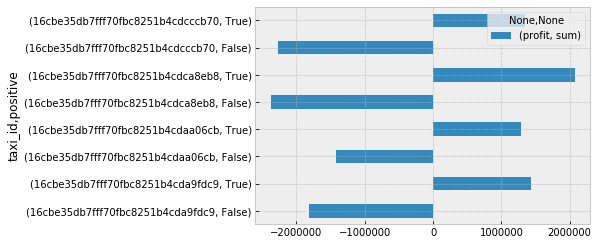

In [342]:
##Looking if top taxi_id with the highest negative profit had positive profit


df_dp_taxi = df_dp[(df_dp['taxi_id'].isin(('16cbe35db7fff70fbc8251b4cdca8eb8', '16cbe35db7fff70fbc8251b4cdcccb70', '16cbe35db7fff70fbc8251b4cda9fdc9', '16cbe35db7fff70fbc8251b4cdaa06cb')))]
df_dp_taxi.sort_values(by=[('profit')], ascending=True)
df_dp_taxi['positive'] = df_dp_taxi['profit'] > 0
df_dp_taxi.groupby(['taxi_id', 'positive']).agg({'profit':['sum']}).plot(kind='barh')

Negative profit it's not directly related to some taxi_ids because from some of the selected, there were journeys with positive and negative profit.

In [328]:
#Explore by driver_id


df_dp_np.groupby(['driver_id']).agg({'journey_id': ['size'],'profit': ['sum']}).sort_values(by=[('profit', 'sum')], ascending=True)

journey_id     profit
                                       size        sum
driver_id                                             
c814db2127582cf95dea1f74f43127c2         24 -2807716.0
ff5c924e0b630fd7c019a4234059fdf4         19 -2426808.0
406921adcca37705ef527b4246c0cfea         16 -2276476.0
d665fb9f75ef5d9cd0fd89479380ba78         14 -1826425.0
ab581e277813d5d9ff98d03b1c96a13f         23 -1322879.0
ec84a73745199ff840ecafcb924383ad          7 -1230826.0
406921adcca37705ef527b4246bbbff5         15 -1065771.0
ae06c34243f741e203e97c48ebcbd9da          5 -1011590.0
40187316352d2c03ddc19e9c8ad7c514          4  -868038.0
6e168888d1ec73590b7ea371548757b5          3  -540915.0
583949a89a9ee17d19e3ca4f137b6b4c          4  -390033.0
23d3dae9d68c241a9b591f35ee5b18cd          3  -363956.0
17c21284245ff240c7212732991c2373          3  -259924.0
eef4aeee867d60d44e1d077d16054b6a         15  -248444.0
d04f1a596fe4a582f48e6eb2f9e8f617         28  -238401.0
56f59b58bcbbd1cdabc3652e713134c2          7  -230850.0
b66c43e298753a3d39220e53008a4325          5  -227496.0
fb81277200c0aea311ad85f90d548d5a          8  -215413.0
3abce16ea601affbeae8f50584ce72ef          2  -208281.0
0aa51cbf1d21c8c6462dbf0e10028a07          3  -173118.0
17c21284245ff240c7212732991c37ac          2  -166517.0
c75c6643b92e4b184d71197e0ff9d34d          2  -158757.0
b66c43e298753a3d39220e53008a1eb8          3  -152273.0
992347d5c59f47b13b14442c6dac8d15          1  -123803.0
294e869d187357cad25b8af65aa6a196         15  -116242.0
ecdcce0c956e266ed26c80fd9e5cbb8f          2  -111744.0
9653e4379509630affa82d7744c825ec          6   -98910.0
6e82410a7a2444e1199e6adb2f3bf6ba          2   -97784.0
ecdcce0c956e266ed26c80fd9e1c188c          2   -86541.0
e84fda9c5df33f03c89b6923c361fb35          4   -76644.0
ccfcfc81abe6485b505ba742749e6b8b          2   -60561.0
b862b75318ed157b2e574a204c8edd8a          1   -45466.0
54c88ff5110a79082d341066aa461e61          1   -40146.0
a86217dc9fc6e34f29bbbcc62973ecd1          2   -35602.0
c3500f8a4f27db46fc9d42e205ec2773          1   -34300.0
81771803646e88efe073786dd2369823          2   -33434.0
389bfa333ba8fa7281dd5f0e1b57c0c1          1   -31800.0
633dbc6b4e8edc3bf01b07b01ab543fe          1   -30800.0
ccfcfc81abe6485b505ba742749e61aa          2   -29525.0
593ae49af455f324457edc1472aee6ad          3   -25311.0
fa5c3d1ad73379ba86b960210e63d537          1   -24106.0
2c0d4219e4cbb7a3e50a9e23e5428beb          1   -21300.0
1d8ba0bdacccf2d0d70ee9925185d231          1   -20182.0
d2f1475850c213560abdec5deae0ee5f          2   -19462.0
6149ad309c203f14b7f56a106a9b32c6          1   -19401.0
1238e44402a93366489cbff9884bc267          1   -19300.0
62c2e39787aa19cd2513901cf3b4858d          2   -16800.0
593ae49af455f324457edc1472ae6cce          6   -14819.0
0fd4a08189ac948f6beaa2d314c6a7ea          1   -14416.0
40f9b1eb345ad0d019630b73d2599bd3          2   -14334.0
12c472dd8efc6ed622ae8669251b82f1          1   -14300.0
8d6e3838b34e9c7181ac358dbc30bfe1          1   -11000.0
38e92872d3aa0417293e90d813f99d65          1    -9272.0
12c472dd8efc6ed622ae8669257e9ec9          1    -8300.0
8ff94ac5183d99dc41b042ad5cb1e655          1    -8034.0
761737b194876dd53761a03c958f7660          1    -6983.0
b68895736389f2949faa8c73555b81ac          5    -4796.0
883360491194dd3b866c897b258b53bf          3    -3981.0
b4f2c132de1648fecf41bb1651525c91          1    -3525.0
baacf396f773709519bbde35a5eab861          1    -3518.0
8ed36e0e9dbf62743c06c09e5f6b5be7          2    -3411.0
406921adcca37705ef527b4246c19db3         10    -2331.0
b5ad67a3c92f78510e3bd10d9f4c021e          1    -2207.0
27c157e605c56c7df70c605963e1d386          2    -2083.0
65b6f3b7075270499ddd0f1dc1130459         11    -2082.0
bf42c5e0c312b97496ef6716c857f856          1    -1757.0
8cacd92bb3ea82079e446fd4b8fd9816          1    -1703.0
c9f8bf073d7b1de4ad57f4466b0efde9          1    -1650.0
54b4de3c953be7d11a1ea3e2b545181d          1     -642.0
784a730957c6e05508e71c604ac92700          1     -450.0
b5ad67a3c92f78510e

<ipython-input-340-aab29d9511d6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dp_driver['positive'] = df_dp_driver['profit'] > 0


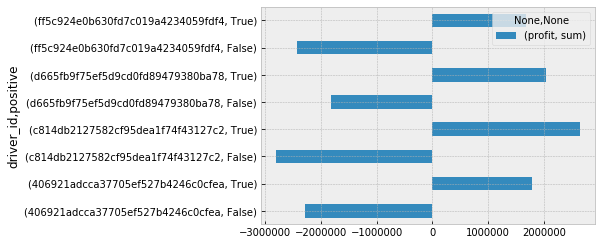

In [340]:
##Checking info for top drivers by negative profit

df_dp_driver = df_dp[(df_dp['driver_id'].isin(('c814db2127582cf95dea1f74f43127c2', 'ff5c924e0b630fd7c019a4234059fdf4', '406921adcca37705ef527b4246c0cfea', 'd665fb9f75ef5d9cd0fd89479380ba78')))]
df_dp_driver['positive'] = df_dp_driver['profit'] > 0
df_dp_driver.groupby(['driver_id', 'positive']).agg({'profit':['sum']}).plot(kind='barh')

I would have liked to draw the chart in red for negative profit and green for the positive to show that negative profit is not related directly to exclusive drivers

### Exploring drivers, how many, how was the evolution through 2010 and if there is driver info for all journeys

In [347]:
df_dp['driver_id'].nunique()

166

In [349]:
df_dp.groupby(['start_month']).agg({'driver_id': ['nunique']})

driver_id
              nunique
start_month          
2010-01-01         40
2010-02-01         44
2010-03-01         48
2010-04-01         51
2010-05-01         54
2010-06-01         54
2010-07-01         54
2010-08-01         68
2010-09-01         61
2010-10-01         73
2010-11-01         72
2010-12-01         75

There were a total of 166 drivers during 2010, but the number of drivers linked to the app has increased during last months of the year 2010.

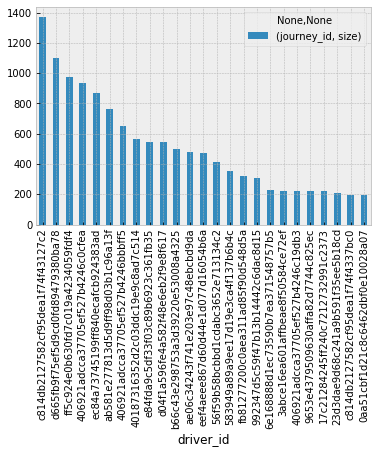

In [353]:
df_dp.groupby(['driver_id']).agg({'journey_id': ['size']}).sort_values(by=[('journey_id', 'size')], ascending=False).head(25).plot(kind='bar')

In [359]:
## Is there any journey without driver information?

df_dp[(df_dp['driver_id'].isnull())]

Empty DataFrame
Columns: [journey_id, user_id, driver_id, taxi_id, icon, start_type, start_at, start_lat, start_lon, end_at, end_lat, end_lon, end_state, driver_start_lat, driver_start_lon, arrived_at, currency, price, price_distance, price_duration, distance, duration, cost, cost_distance, cost_duration, source, driver_score, rider_score, start_location, start_country, start_city, end_location, end_country, end_city, start_month, start_day, profit, theoretical_profit]
Index: []

[0 rows x 38 columns]

There is no null driver info for drop-off ended journeys.

In [364]:
df_driver_null = df[(df['driver_id'].isnull())]
pd.pivot_table(df_driver_null, values = ['driver_id'],
                    columns=['end_state'], aggfunc=('size'))

end_state
failure          249
not found       1143
rider cancel    1981
dtype: int64

There is no info for journeys that were failed, not found or cancelled by the rider.

#### Preparing slides -- Extra checks

In [242]:
#Q4 journeys

df_dp[(df_dp['start_month'].isin(('2010-10-01','2010-11-01','2010-12-01')))]['start_month'].value_counts()

2010-12-01    2553
2010-11-01    2415
2010-10-01    2414
Name: start_month, dtype: int64

In [243]:
df['start_month'] = pd.to_datetime(df['start_at'].values.astype('datetime64[M]'))

df[(df['start_month'].isin(('2010-10-01','2010-11-01','2010-12-01')))]['start_month'].value_counts()

2010-12-01    3313
2010-10-01    3240
2010-11-01    3021
Name: start_month, dtype: int64

In [283]:
df_dp['profit'] = df_dp['price'].fillna(0) - df_dp['cost'].fillna(0)
df_dp['profit'].sum()

<ipython-input-283-fb0b2a6969e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dp['profit'] = df_dp['price'].fillna(0) - df_dp['cost'].fillna(0)


4782892.0

In [284]:
df_dp[(df_dp['start_month'].isin(('2010-10-01','2010-11-01','2010-12-01')))]['profit'].sum()

113437.0

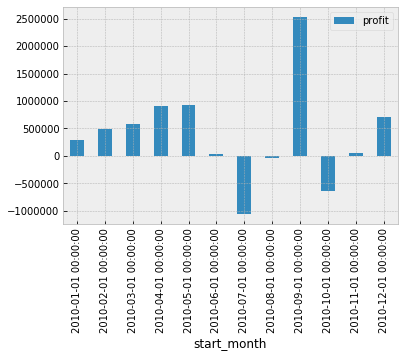

In [285]:
#Checking profit
df_dp.groupby('start_month').agg({'profit':'sum'}).plot.bar()

In [286]:
df_dp[(df_dp['start_month'] == '2010-10-01')]['driver_score'].value_counts()

5.0    563
4.0    255
3.0     29
1.0     10
2.0      6
0.0      5
Name: driver_score, dtype: int64

In [287]:
#Checking negative profit for October fetching some examples
df_dp[(df_dp['start_month'] == '2010-10-01') & (df_dp['profit'] < 0)][['journey_id', 'driver_id', 'start_at','driver_score','duration', 'price', 'price_duration',  'cost', 'cost_duration', 'profit']]

journey_id                         driver_id  \
1332   a8bcf2fd1f8604fe133486cd224833dc  406921adcca37705ef527b4246c0cfea   
4615   c4a68319b56f162b8669a5622a5cb72b  e84fda9c5df33f03c89b6923c361fb35   
4866   e49eb2cdf4d249c5eba673cb802fb552  ae06c34243f741e203e97c48ebcbd9da   
4867   fb6fe821f9f6cf0f22b44771b7619644  62c2e39787aa19cd2513901cf3b4858d   
5230   91ace458f877ac65d28e93559c8ea9b4  d2f1475850c213560abdec5deae0ee5f   
7529   5451a6de23c7004ee934134edd769c9d  d04f1a596fe4a582f48e6eb2f9e8f617   
7606   584a3faf5a5c62c4fb996f80ec017829  ae06c34243f741e203e97c48ebcbd9da   
8448   91ace458f877ac65d28e93559c8f0ff6  ec84a73745199ff840ecafcb924383ad   
11348  c4a68319b56f162b8669a5622a7ca0f9  ccfcfc81abe6485b505ba742749e61aa   
11349  e49eb2cdf4d249c5eba673cb800d105c  c75c6643b92e4b184d71197e0ff9d34d   
11350  3a7612ec4e3d410575e2c428b0a90a12  ccfcfc81abe6485b505ba742749e6b8b   
11351  e013d5709301badd8c2f27b0010fd044  ab581e277813d5d9ff98d03b1c96a13f   
11352  e013d5709301badd8c2f27b0010e8ed6  40187316352d2c03ddc19e9c8ad7c514   
11353  d714d3665aaaf6f748ce2d52f48aebe3  3abce16ea601affbeae8f50584ce72ef   
12693  3a7612ec4e3d410575e2c428b0893722  b66c43e298753a3d39220e53008a4325   
13558  2929303fb45ee25ef6cbe4cc60328137  fb81277200c0aea311ad85f90d548d5a   
13564  3a7612ec4e3d410575e2c428b0a8813b  23d3dae9d68c241a9b591f35ee5b18cd   
15423  f6254a51b033dcea52c37c715b3fb278  c9f8bf073d7b1de4ad57f4466b0efde9   
15460  f1e4317f2c17991dd90d1cd17a5d630a  8ff94ac5183d99dc41b042ad5cb1e655   
15618  d714d3665aaaf6f748ce2d52f48b9981  eef4aeee867d60d44e1d077d16054b6a   
15619  a89e50234bb6c1a61101ba24c47e03a0  9653e4379509630affa82d7744c825ec   
15620  91ace458f877ac65d28e93559c6af982  ff5c924e0b630fd7c019a4234059fdf4   
15621  e49eb2cdf4d249c5eba673cb80309c2d  583949a89a9ee17d19e3ca4f137b6b4c   
15622  85958894ecd5ca02684c6ec53123033d  17c21284245ff240c7212732991c37ac   
15849  b29a1d305204236814667bb1c1e4b931  6e168888d1ec73590b7ea371548757b5   
16274  1e6632f5c81b1cb094d200252bb4aee4  eef4aeee867d60d44e1d077d16054b6a   
17084  82cd22b35b81b11925488cba1e29aec9  8cacd92bb3ea82079e446fd4b8fd9816   
17768  85958894ecd5ca02684c6ec531e59ff9  593ae49af455f324457edc1472aee6ad   
17819  91ace458f877ac65d28e93559c69b3d7  56f59b58bcbbd1cdabc3652e713134c2   
17858  358741ec2409c505c4545c3866c314fd  406921adcca37705ef527b4246c0cfea   
20423  f6254a51b033dcea52c37c715ba4bbed  593ae49af455f324457edc1472ae6cce   
20433  15ed4199b937f56b5257f698df66cd9d  593ae49af455f324457edc1472ae6cce   
20724  91ace458f877ac65d28e93559c697888  81771803646e88efe073786dd2369823   
20725  91ace458f877ac65d28e93559ccf49a9  0aa51cbf1d21c8c6462dbf0e10028a07   
20726  e49eb2cdf4d249c5eba673cb800db528  d665fb9f75ef5d9cd0fd89479380ba78   
20727  7b894f8002c2ab22f7c385ddb3eca1dc  40f9b1eb345ad0d019630b73d2599bd3   
20728  e49eb2cdf4d249c5eba673cb8077ec71  c814db2127582cf95dea1f74f43127c2   
22430  5451a6de23c7004ee934134edd74f628  c814db2127582cf95dea1f74f43127c2   
23107  f1e4317f2c17991dd90d1cd17ae0d399  17c21284245ff240c7212732991c2373   

                 start_at  driver_score  duration    price  price_duration  \
1332  2010-10-05 20:05:00           5.0       0.0   1949.0             0.0   
4615  2010-10-04 23:00:00           NaN     254.0   1700.0           211.0   
4866  2010-10-02 17:15:35           NaN       3.0   8003.0             2.0   
4867  2010-10-17 15:00:00           4.0     127.0   1700.0           106.0   
5230  2010-10-02 14:42:36           NaN     524.0   1700.0           436.0   
7529  2010-10-07 13:53:48           NaN    1752.0   1700.0          1460.0   
7606  2010-10-02 10:50:00           NaN    3100.0   8605.0          2570.0   
8448  2010-10-02 12:52:13           NaN     433.0   2054.0           361.0   
11348 2010-10-03 19:30:00           NaN     157.0   4441.0           131.0   
11349 2010-10-02 18:32:43           NaN    1963.0   4196.0          1636.0   
11350 2010-10-02 13:00:00           NaN    1882.0   3853.0          1568.0   
11351 2010-1

In [288]:
#Reducing the dataframe to the duration lower than 500 for checking price, cost, profit, score 
df_dp[(df_dp['duration'] < 500)][['journey_id', 'driver_id', 'start_at','driver_score','duration', 'price', 'price_duration',  'cost', 'cost_duration', 'profit']]

journey_id                         driver_id  \
0      23a1406fc6a11d866e3c82f22eed4d4c  583949a89a9ee17d19e3ca4f137b6b4c   
6      12432d83b49393bf25164673212b8295  e1332f68e81526e498e4d845233a6d7d   
7      2e51db3a8a77aa594aa686ff19fe6036  d665fb9f75ef5d9cd0fd89479380ba78   
8      0234eb5f7e99d581c72052f0a868289c  d04f1a596fe4a582f48e6eb2f9e8f617   
10     297c055e30be8d9a933868c94980a7df  d04f1a596fe4a582f48e6eb2f9e8f617   
11     af7a0d5b65562d9e4f7749317efb1a3a  d04f1a596fe4a582f48e6eb2f9e8f617   
12     ea91d2d997d84fbfddbd2657db7bec90  633dbc6b4e8edc3bf01b07b01ab543fe   
13     ea91d2d997d84fbfddbd2657db7cad2e  e84fda9c5df33f03c89b6923c361fb35   
15     4d099d2850587a481735551982f06342  65b6f3b7075270499ddd0f1dc11d4e11   
16     196d9de717b4c8d6ec0f19c0e8c0dd9b  e84fda9c5df33f03c89b6923c361fb35   
17     761a1b1e8e4103f2ac5a42556413e2e7  d665fb9f75ef5d9cd0fd89479380ba78   
19     15ed4199b937f56b5257f698df652a24  d04f1a596fe4a582f48e6eb2f9e8f617   
21     7abecd4f47c2c1d5390d86eb221babff  406921adcca37705ef527b4246c0cfea   
23     23be2836bd1f20bf05c9ffa3aa6db37c  406921adcca37705ef527b4246c0cfea   
25     b8ae7685c97ef64f90a646a3b97ed4c0  d665fb9f75ef5d9cd0fd89479380ba78   
26     031fea9628f9238b051a58808553bb49  031fea9628f9238b051a58808554498a   
31     6b1a92b6b49faa86680739acb21fb5d8  b66c43e298753a3d39220e53008a1eb8   
35     51d71b143d0f21b1ffb195c827f07c8f  ecdcce0c956e266ed26c80fd9e5cbb8f   
36     2b6180ec6aab8e8ad2d066c643ab4a71  992347d5c59f47b13b14442c6dac8d15   
37     96acbfbef7034b4ff82c5989bbe17759  d665fb9f75ef5d9cd0fd89479380ba78   
38     95d99d0ddfe26fb80887f15fa99b0e8d  d04f1a596fe4a582f48e6eb2f9e8f617   
40     a37ccff55ca3cff97b19b45ab2d9d627  ab581e277813d5d9ff98d03b1c96a13f   
42     124dc2dbc4f79130bfa0b935778af97f  3d68e1172f35c1fbd06db5a1bc1824a3   
48     70ba4ba5a1d09c1213940afbf8cc84be  ee1db66c3d95a0d86b05c27d18689fdc   
49     a553c46e3a22fb9c326aeb3d72aff619  d665fb9f75ef5d9cd0fd89479380ba78   
53     e013d5709301badd8c2f27b001110178  ae06c34243f741e203e97c48ebcbd9da   
56     2f1882c87731970df63e69d4bc27cea4  d04f1a596fe4a582f48e6eb2f9e8f617   
58     55083e0137c0a9c7a82afecab6263984  e84fda9c5df33f03c89b6923c361fb35   
59     fdf02c2d7b2dd9c0c7eb0b0b729cc655  d665fb9f75ef5d9cd0fd89479380ba78   
64     0756e1a1be3313a1a223bc6eb847aa83  d665fb9f75ef5d9cd0fd89479380ba78   
66     7d696ae0f1d27b6b752121cffbd3842e  3a9ca0965227dc470f30145e41e898d1   
74     b6206048fbda6d454ead4fa2b48ff9f1  d04f1a596fe4a582f48e6eb2f9e8f617   
75     cd5b1508243ee5653060d649cf2e2570  62c2e39787aa19cd2513901cf3b4858d   
77     277551ace9ebc79f176d0f3574a127dc  baacf396f773709519bbde35a5eab861   
78     cc82cce36f58bc6f3451ce6b93610457  baacf396f773709519bbde35a5eab861   
79     1e041deffa3920bbde0b20cd810c0ec4  e84fda9c5df33f03c89b6923c361fb35   
82     4b0e911c7e5b79f6d929b016837a99ef  d665fb9f75ef5d9cd0fd89479380ba78   
86     621c9b8da5001877cc902b7b4ce1d403  992347d5c59f47b13b14442c6dac8d15   
88     7d3c2e2ccb10710c9877b709b818e9fe  d665fb9f75ef5d9cd0fd89479380ba78   
89     eeb07ac5409c082354b923689340c1ab  406921adcca37705ef527b4246c0cfea   
90     eeb07ac5409c082354b923689342bbe6  406921adcca37705ef527b4246c0cfea   
96     09c9677134007a306b71d1df0ee08e2f  62c2e39787aa19cd2513901cf3b4858d   
100    fdd0e7184d1ec5e7cba69b61ee4b94bc  406921adcca37705ef527b4246c0cfea   
109    532278dfa8891ad6dd958337e4cc9a16  d04f1a596fe4a582f48e6eb2f9e8f617   
110    11c41f4761b7f551f68781d2624a0a95  992347d5c59f47b13b14442c6dac8d15   
115    949be0368739d589fed232ad8871d470  e84fda9c5df33f03c89b6923c361fb35   
118    fd4143bc419bb1b2a06746705405f078  baacf396f773709519bbde35a5eab861   
121    dd23cf0ef33ae44e0c0b4c756e1d9293  d665fb9f75ef5d9cd0fd89479380ba78   
122    1881c928349fa432c4c0cb4434de4085  992347d5c59f47b13b14442c6dac8d15   
123    2f1882c87731970df63e69d4bc1ec157  d665fb9f75ef5d9cd0fd89479380ba78   
125    807f274d7a99210e52857364d84c1449  992347d5c59f47b13b14442c6dac8d15   
134    ae12edba2cff83f08c